In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import math
import seaborn as sns
from functools import reduce
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import explained_variance_score

In [2]:
# Need to be able to see all columns
pd.set_option('display.max_columns', 999)

In [3]:
crime = pd.read_csv("./data/crime.csv", low_memory=False).add_prefix("crime_")
crime.name = "crime"

In [4]:
crime.head()

,crime_INCIDENT_NUMBER,crime_OFFENSE_CODE,crime_OFFENSE_CODE_GROUP,crime_OFFENSE_DESCRIPTION,crime_DISTRICT,crime_REPORTING_AREA,crime_SHOOTING,crime_OCCURRED_ON_DATE,crime_YEAR,crime_MONTH,crime_DAY_OF_WEEK,crime_HOUR,crime_UCR_PART,crime_STREET,crime_Lat,crime_Long,crime_Location
0,I192078648,3114,Investigate Property,INVESTIGATE PROPERTY,B3,427,NaN,2019-09-29 06:39:00,2019,9,Sunday,6,Part Three,WILMORE ST,42.277964,-71.092463,"(42.27796370, -71.09246318)"
1,I192078647,3115,Investigate Person,INVESTIGATE PERSON,A1,,NaN,2019-09-29 03:45:00,2019,9,Sunday,3,Part Three,NASHUA ST,42.367690,-71.065863,"(42.36769032, -71.06586347)"
2,I192078645,3301,Verbal Disputes,VERBAL DISPUTE,B3,450,NaN,2019-09-29 06:00:00,2019,9,Sunday,6,Part Three,ASPINWALL RD,42.291816,-71.072441,"(42.29181580, -71.07244098)"
3,I192078642,3820,Motor Vehicle Accident Response,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY,D4,269,NaN,2019-09-29 05:50:00,2019,9,Sunday,5,Part Three,ALBANY ST,42.332419,-71.075013,"(42.33241896, -71.07501315)"
4,I192078640,3115,Investigate Person,INVESTIGATE PERSON,A7,28,NaN,2019-09-29 01:30:00,2019,9,Sunday,1,Part Three,PARIS ST,42.373392,-71.036478,"(42.37339168, -71.03647779)"


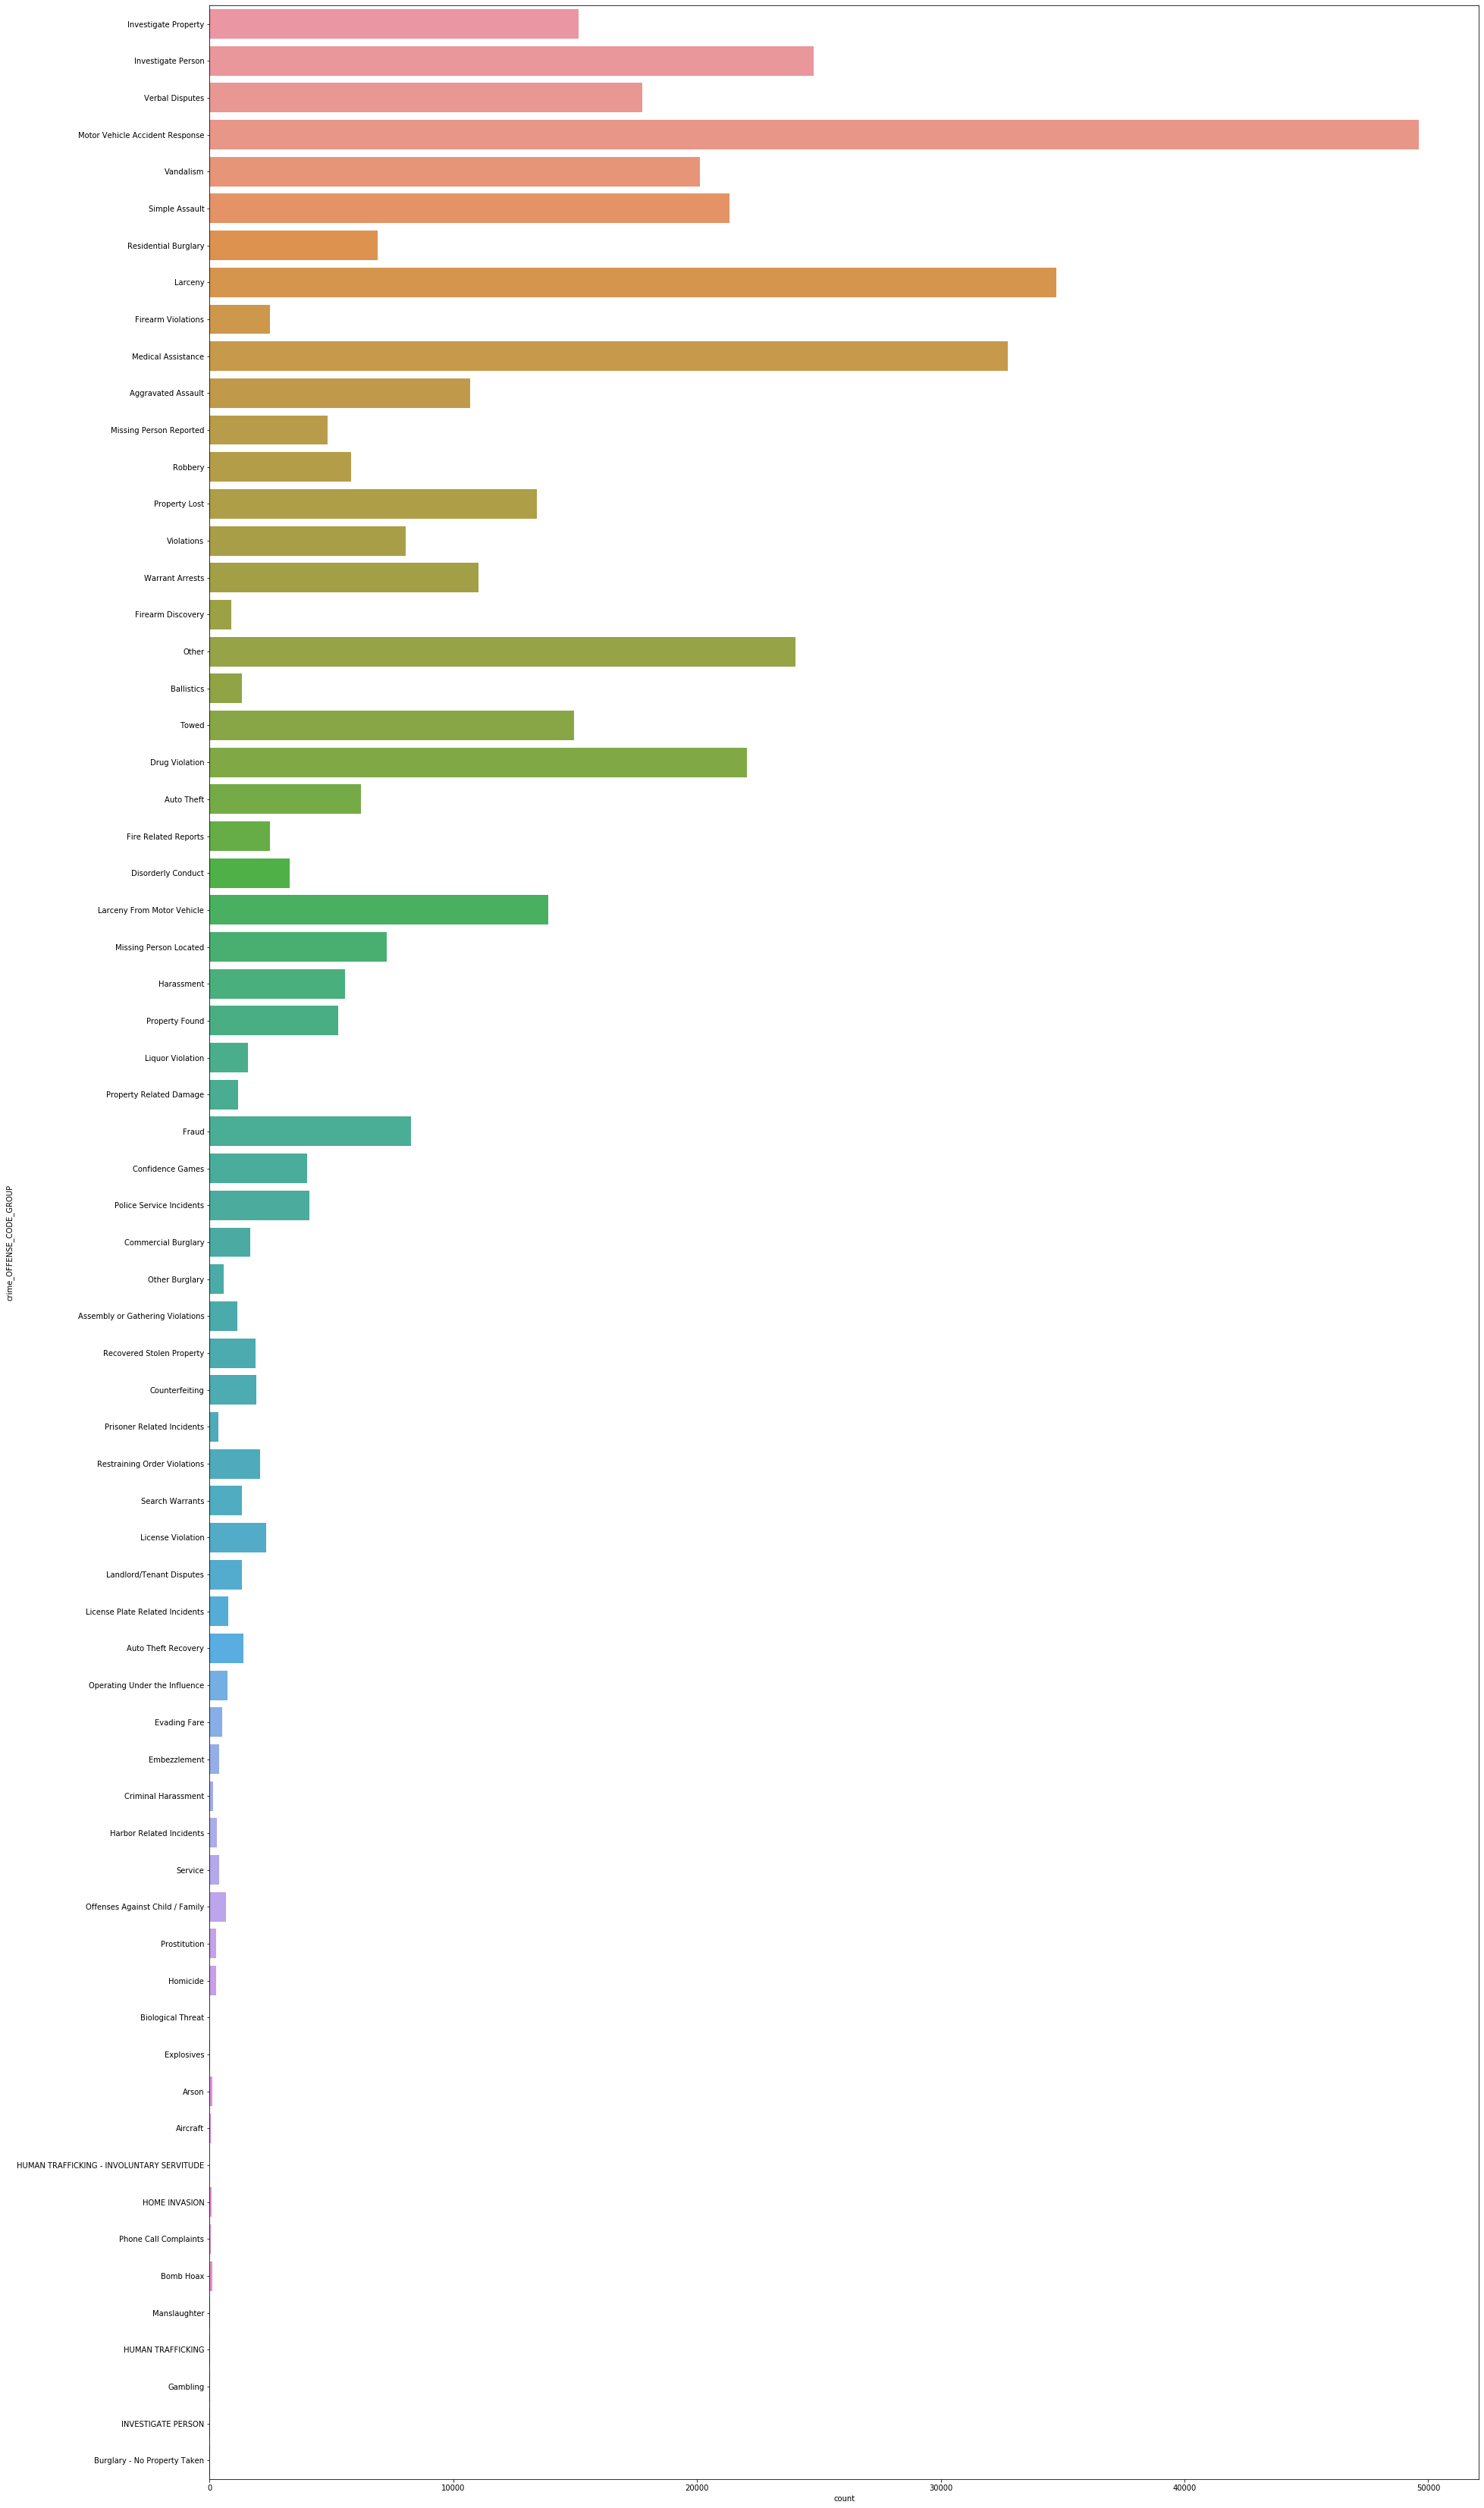

In [5]:
plt.figure(figsize=(30, 60))    #We are giving the size of figure
sns.countplot(y=crime.crime_OFFENSE_CODE_GROUP)  #countplot taking counts of the columns which you choose 
plt.show()

In [6]:
crime = crime[crime.crime_OFFENSE_CODE_GROUP != 'Motor Vehicle Accident Response']
crime = crime[crime.crime_OFFENSE_CODE_GROUP != 'Medical Assistance']

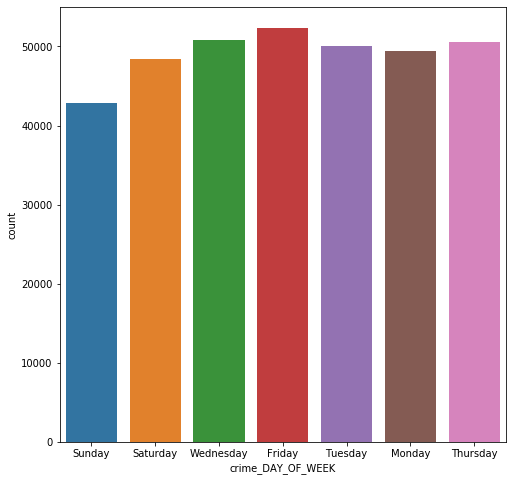

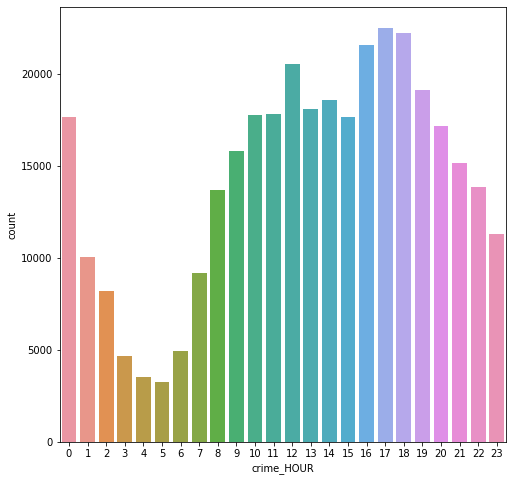

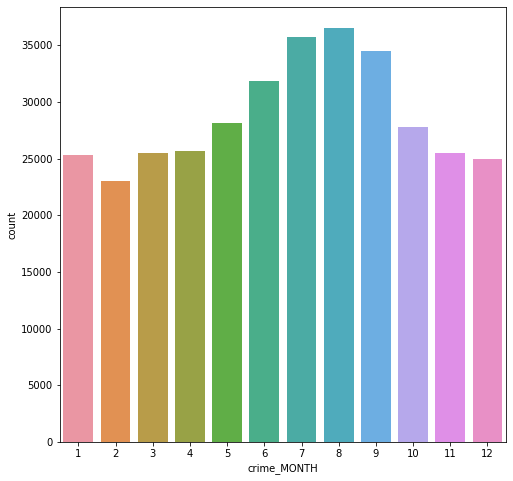

In [7]:
plt.figure(figsize=(8,8))    #We are giving the size of figure
sns.countplot(x=crime.crime_DAY_OF_WEEK)  #countplot taking counts of the columns which you choose 
plt.show() 

plt.figure(figsize=(8,8))    
sns.countplot(x=crime.crime_HOUR)  
plt.show() 

plt.figure(figsize=(8, 8))    
sns.countplot(x=crime.crime_MONTH)  
plt.show() 

In [8]:
police = pd.read_csv("./data/police_sta.csv").add_prefix("police_")
fire = pd.read_csv("./data/fire_dept.csv").add_prefix("fire_")
community = pd.read_csv("./data/community_centers.csv").add_prefix("community_")
parks = pd.read_csv("./data/parks.csv").add_prefix("parks_")

police.name = "police"
fire.name = "fire"
community.name = "community"
parks.name = "parks"

In [9]:
humidity = pd.read_csv("./data/weather/humidity.csv")
temp = pd.read_csv("./data/weather/temperature.csv")
pressure = pd.read_csv("./data/weather/pressure.csv")
weather_descript = pd.read_csv("./data/weather/weather_description.csv")
wind_dir = pd.read_csv("./data/weather/wind_direction.csv")
wind_speed = pd.read_csv("./data/weather/wind_speed.csv")

humidity.name = "humidity"
temp.name = "temperature"
pressure.name = "pressure"
weather_descript.name = "weather_description"
wind_dir.name = "wind_direction"
wind_speed.name = "wind_speed"

In [10]:
bos_weather = []
for df in [humidity, temp, pressure, weather_descript, wind_dir, wind_speed]:
    df = df.rename({"Boston":df.name}, axis=1)
    bos_weather.append(df)

In [11]:
### NOTE ###
# The following three cells were only to handle the original weather files, which contained many cities
# Code kept for posterity

In [12]:
# The files have many cities in them
#for df in bos_weather:
#    df.drop(list(df.filter(regex="^((?!Boston|datetime).)*$")), axis = 1, inplace=True)

In [13]:
# The scraper didn't specify the temp units, which inexplicably default to Kelvin
#def temp_k_to_f(kelvin):
#    return ((kelvin - 273.15) * 9/5 + 32)
#temp['Boston'] = temp['Boston'].apply(temp_k_to_f)

In [14]:
# And, to save upload space, let's write out our new files
#for df in bos_weather:
#    df.to_csv('./data/weather/' + df.name + '.csv')

In [15]:
# Same as a SQL inner join
weather = reduce(lambda left,right: pd.merge(left,right,on=["datetime"], how="inner"), bos_weather)
weather.drop(weather.filter(regex="Unnamed"), axis=1, inplace=True)

# First row is NaN due to the join, drop it
weather.drop(weather.index[0], inplace=True)
datasets = [crime, police, fire, community, parks, weather]

In [16]:
# There are still some NaNs, so let's fill them with the closest neighbor
weather.isna().any()

datetime               False
humidity                True
temperature             True
pressure                True
weather_description    False
wind_direction         False
wind_speed             False
dtype: bool

In [17]:
weather.fillna(method="ffill", inplace=True)
weather.isna().any()

datetime               False
humidity               False
temperature            False
pressure               False
weather_description    False
wind_direction         False
wind_speed             False
dtype: bool

In [18]:
for df in datasets:
    # Some of the datasets have Lat/Long as Y/X, which can be confusing
    # They also have longcoord and latcoord, but they're unsigned, so dropping them
    # Regex is to avoid partial matching
    df.columns = df.columns.str.replace("^[X]", "long", regex=True)
    df.columns = df.columns.str.replace("^[Y]", "lat", regex=True)
    df.drop(list(df.filter(regex="coord")), axis = 1, inplace=True)
    
    # Makes typing easier
    df.columns = [x.lower() for x in df.columns]

In [19]:
### crime ###
# UCR_PART is Uniform Crime Reporting, and attempts to lump crimes into categories
# This is separate from Boston PD's own categorization
# Can't do anything without Lat/Long, so we'll have to drop those
crime.dropna(subset=["crime_lat", "crime_long"], inplace=True)

# Renaming for consistency
crime = crime.rename({"crime_occurred_on_date":"datetime"}, axis=1)

In [20]:
### police ###

# None of the nulls here matter
police.isnull().any()

police_x               False
police_y               False
police_objectid        False
police_bldg_id         False
police_bid             False
police_address         False
police_point_x         False
police_point_y         False
police_name            False
police_neighborhood    False
police_city            False
police_zip             False
police_ft_sqft          True
police_story_ht         True
police_parcel_id       False
dtype: bool

In [21]:
### fire ###

# Lots of nulls here, but only ones that actually matter are fire_x and fire_y 
# (fire_xcoord and fire_ycoord are the same, but unsigned)
fire.isnull().any()

fire_x             False
fire_y             False
fire_objectid_1    False
fire_objectid       True
fire_bfd_id         True
fire_map_id         True
fire_mapcode        True
fire_loccode        True
fire_locdept        True
fire_locname        True
fire_loccontact     True
fire_locphone       True
fire_locstno        True
fire_locaddr       False
fire_locowner       True
fire_locward        True
fire_locparcl       True
fire_locprect       True
fire_locplan        True
fire_study          True
fire_above          True
fire_above_desc     True
fire_source         True
fire_geoaddress    False
fire_pd            False
fire_ct90           True
fire_xcoord         True
fire_ycoord         True
dtype: bool

In [22]:
### community ###

# None of the nulls here matter
community.isnull().any()

community_x           False
community_y           False
community_fid         False
community_objectid     True
community_site        False
community_phone       False
community_fax          True
community_street      False
community_neigh       False
community_zip         False
dtype: bool

In [23]:
### parks ###

# None of the nulls here matter
parks.isnull().any()

parks_objectid            False
parks_site_name           False
parks_ownership           False
parks_protection           True
parks_typecode            False
parks_district            False
parks_acres               False
parks_address             False
parks_zonagg              False
parks_typelong            False
parks_os_own_jur           True
parks_os_mngmnt            True
parks_pos                 False
parks_pa                  False
parks_alt_name             True
parks_agncyjuris           True
parks_shape_starea__      False
parks_shape_stlength__    False
parks_shapestarea         False
parks_shapestlength       False
parks_park_id              True
parks_region              False
dtype: bool

In [24]:
### weather ###

# No nulls, hooray
weather.isnull().any()

datetime               False
humidity               False
temperature            False
pressure               False
weather_description    False
wind_direction         False
wind_speed             False
dtype: bool

In [25]:
# Need to clean up datetime a bit for the next merge

# Ensure they're in datetime64 format
crime["datetime"] = pd.to_datetime(crime["datetime"].str.replace(".", ":"))
weather["datetime"] = pd.to_datetime(weather["datetime"].str.replace(".", ":"))

# Sort by date
crime.sort_values(by="datetime", inplace=True)
weather.sort_values(by="datetime", inplace=True)

In [26]:
# Since the crime data is from 2015-2019, and weather from 2012-2017, we'd be throwing out
# a lot of data if we only joined on those. As such, we'll examine weather separately
# from the other data, which is assumed (big if) to be static

# Also to consider is the fact that some of the crime reports almost certainly had the
# hour either missing or filled in as 0 by default, so the weather may not always correlate

crime_with_weather = pd.merge_asof(crime, weather, 
                                   on="datetime", 
                                   direction="nearest",
                                   tolerance=pd.Timedelta("1 hour")
                                  )

In [27]:
# Drop the rows for which we don't have weather
crime_with_weather.dropna(subset=["humidity",
                                  "temperature",
                                  "pressure",
                                  "weather_description",
                                  "wind_direction",
                                  "wind_speed"], 
                          inplace=True)

In [28]:
crime_with_weather.head()

,crime_incident_number,crime_offense_code,crime_offense_code_group,crime_offense_description,crime_district,crime_reporting_area,crime_shooting,datetime,crime_year,crime_month,crime_day_of_week,crime_hour,crime_ucr_part,crime_street,crime_lat,crime_long,crime_location,humidity,temperature,pressure,weather_description,wind_direction,wind_speed
0,I152051083,3130,Search Warrants,SEARCH WARRANT,A7,20,NaN,2015-06-15,2015,6,Monday,0,Part Three,PARIS ST,42.377023,-71.032247,"(42.37702319, -71.03224730)",70.0,60.952634,1031.0,scattered clouds,137.0,3.0
1,I152059178,2647,Other,THREATS TO DO BODILY HARM,C11,359,NaN,2015-06-15,2015,6,Monday,0,Part Two,WASHINGTON ST,42.293606,-71.071887,"(42.29360585, -71.07188650)",70.0,60.952634,1031.0,scattered clouds,137.0,3.0
2,I152067251,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,A1,93,NaN,2015-06-15,2015,6,Monday,0,Part Two,FANEUIL HALL SQ,42.360205,-71.056208,"(42.36020464, -71.05620816)",70.0,60.952634,1031.0,scattered clouds,137.0,3.0
3,I162013546,3201,Property Lost,PROPERTY - LOST,B3,433,NaN,2015-06-15,2015,6,Monday,0,Part Three,NORFOLK ST,42.283634,-71.082813,"(42.28363434, -71.08281320)",70.0,60.952634,1031.0,scattered clouds,137.0,3.0
4,I172040657,2629,Harassment,HARASSMENT,C11,397,NaN,2015-06-15,2015,6,Monday,0,Part Two,MELBOURNE ST,42.291093,-71.065945,"(42.29109287, -71.06594539)",70.0,60.952634,1031.0,scattered clouds,137.0,3.0


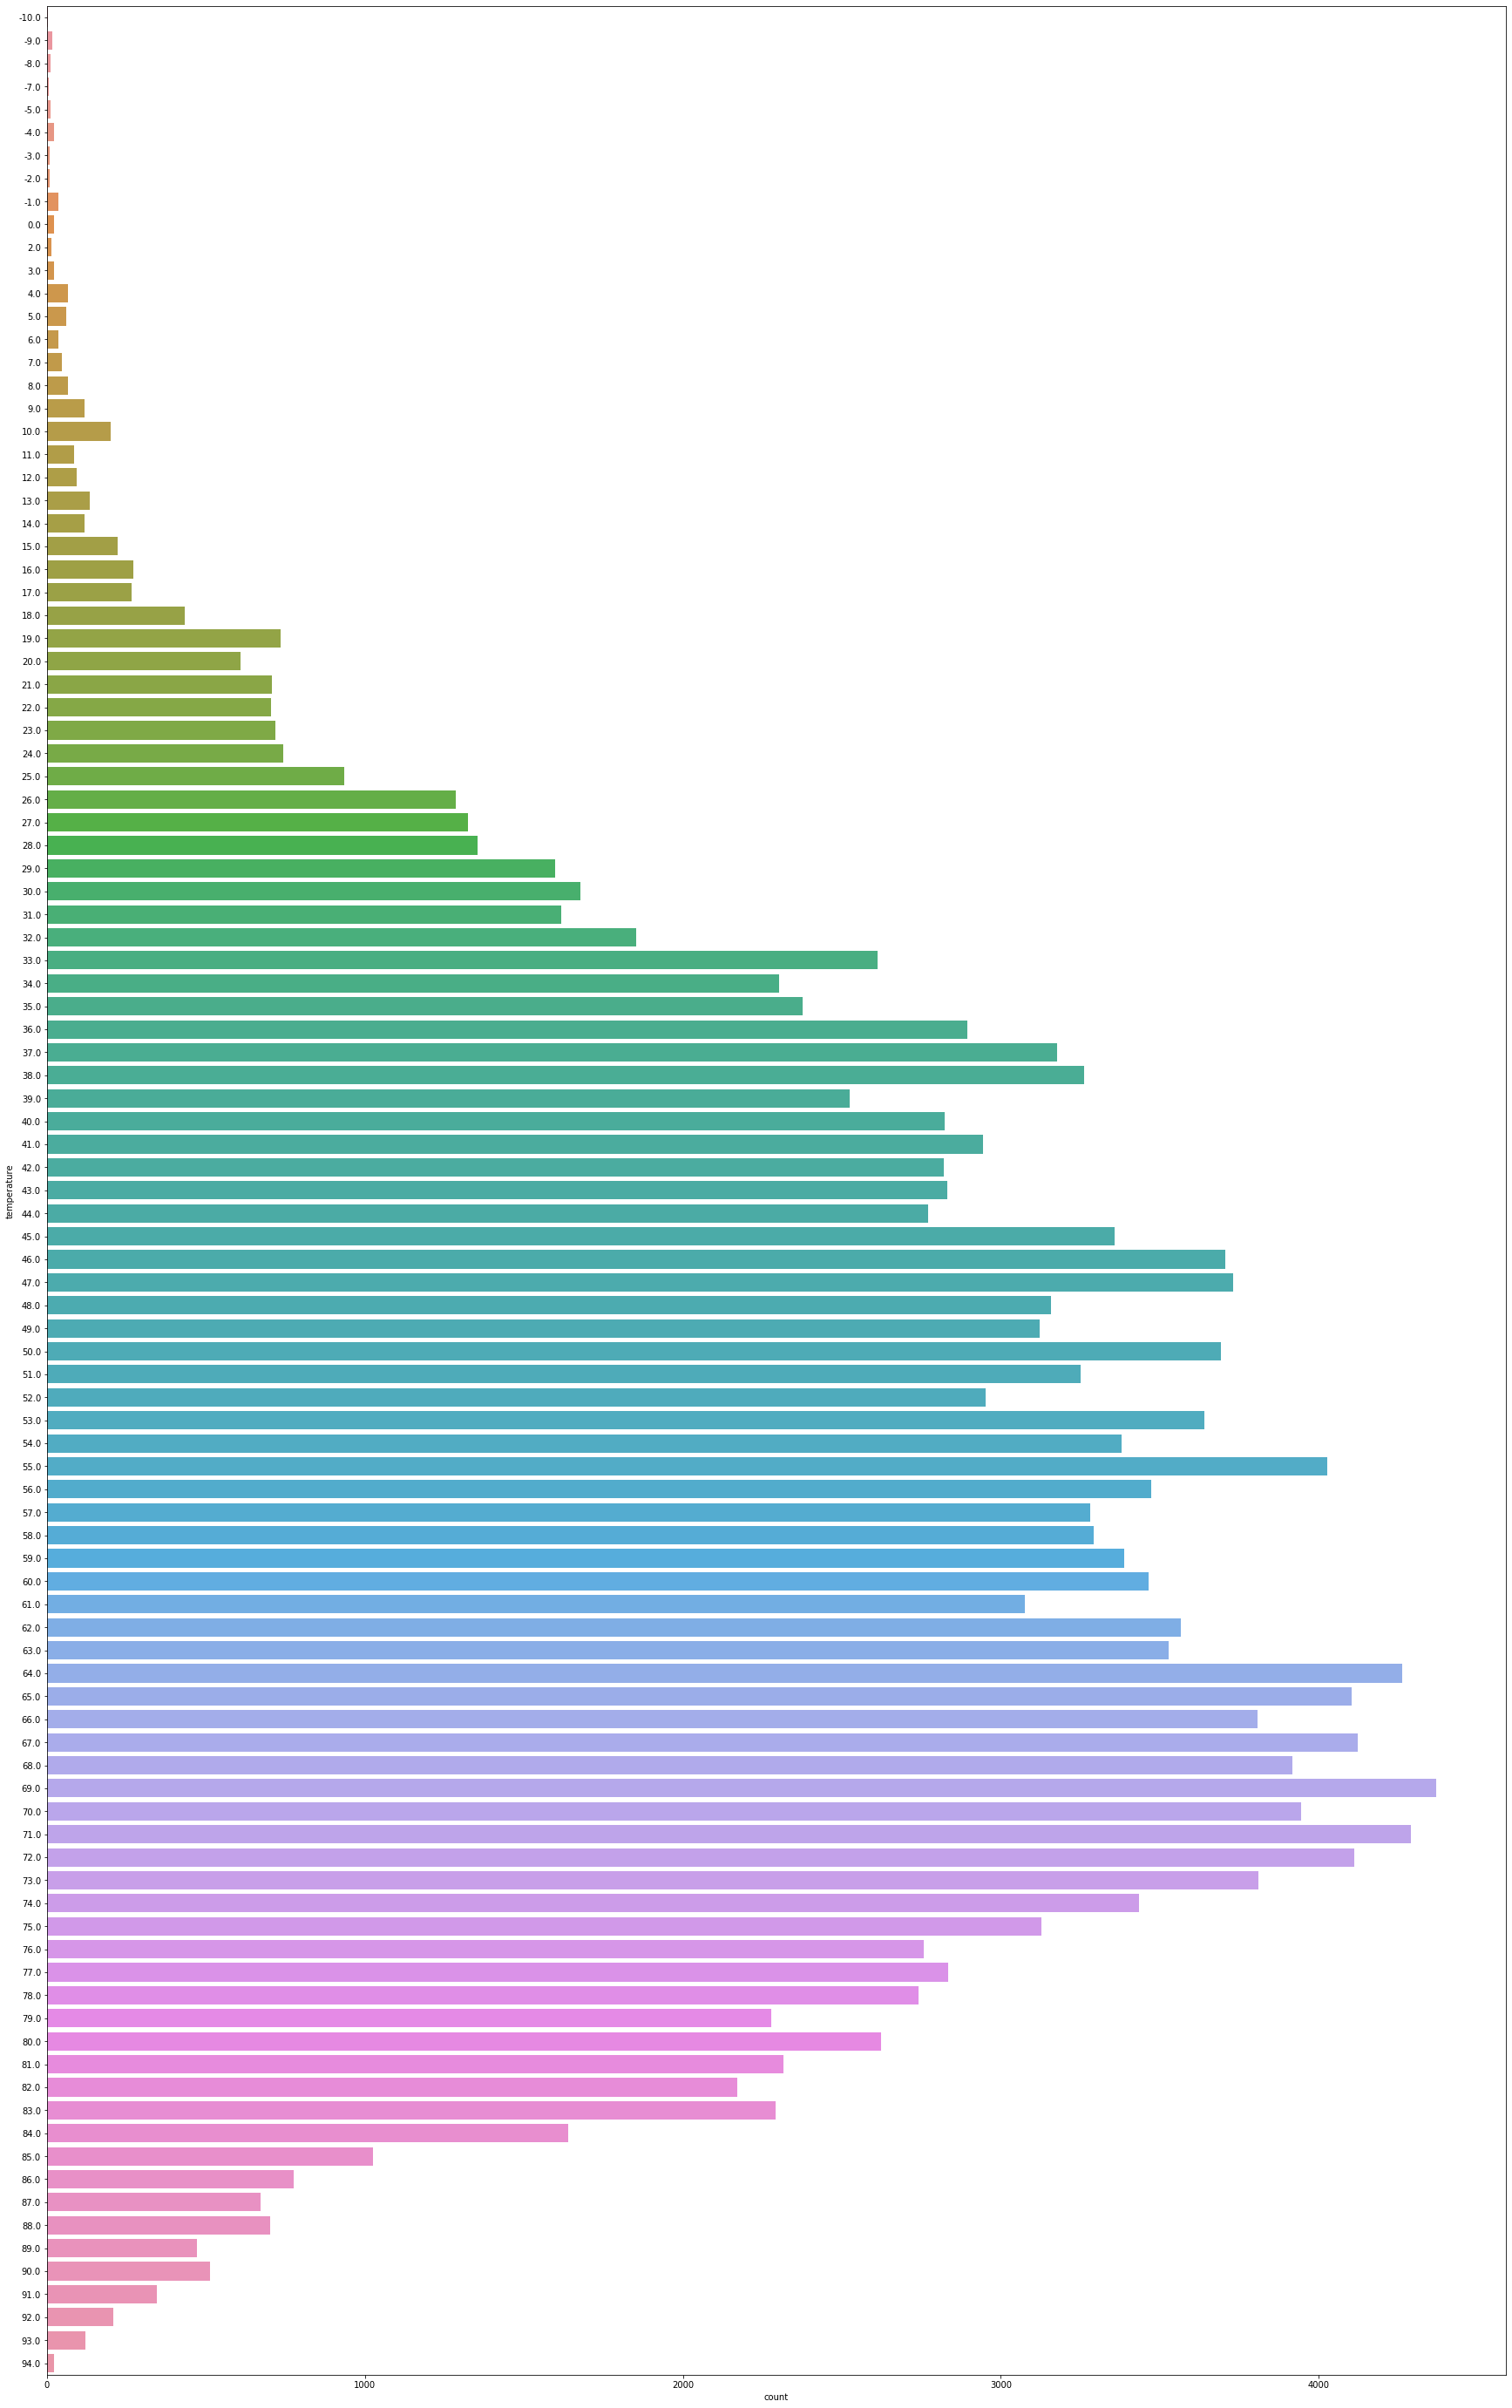

In [29]:
plt.figure(figsize=(30, 50))    #We are giving the size of figure
sns.countplot(y=crime_with_weather.temperature.round(decimals=0))  #countplot taking counts of the columns which you choose 
plt.show() 

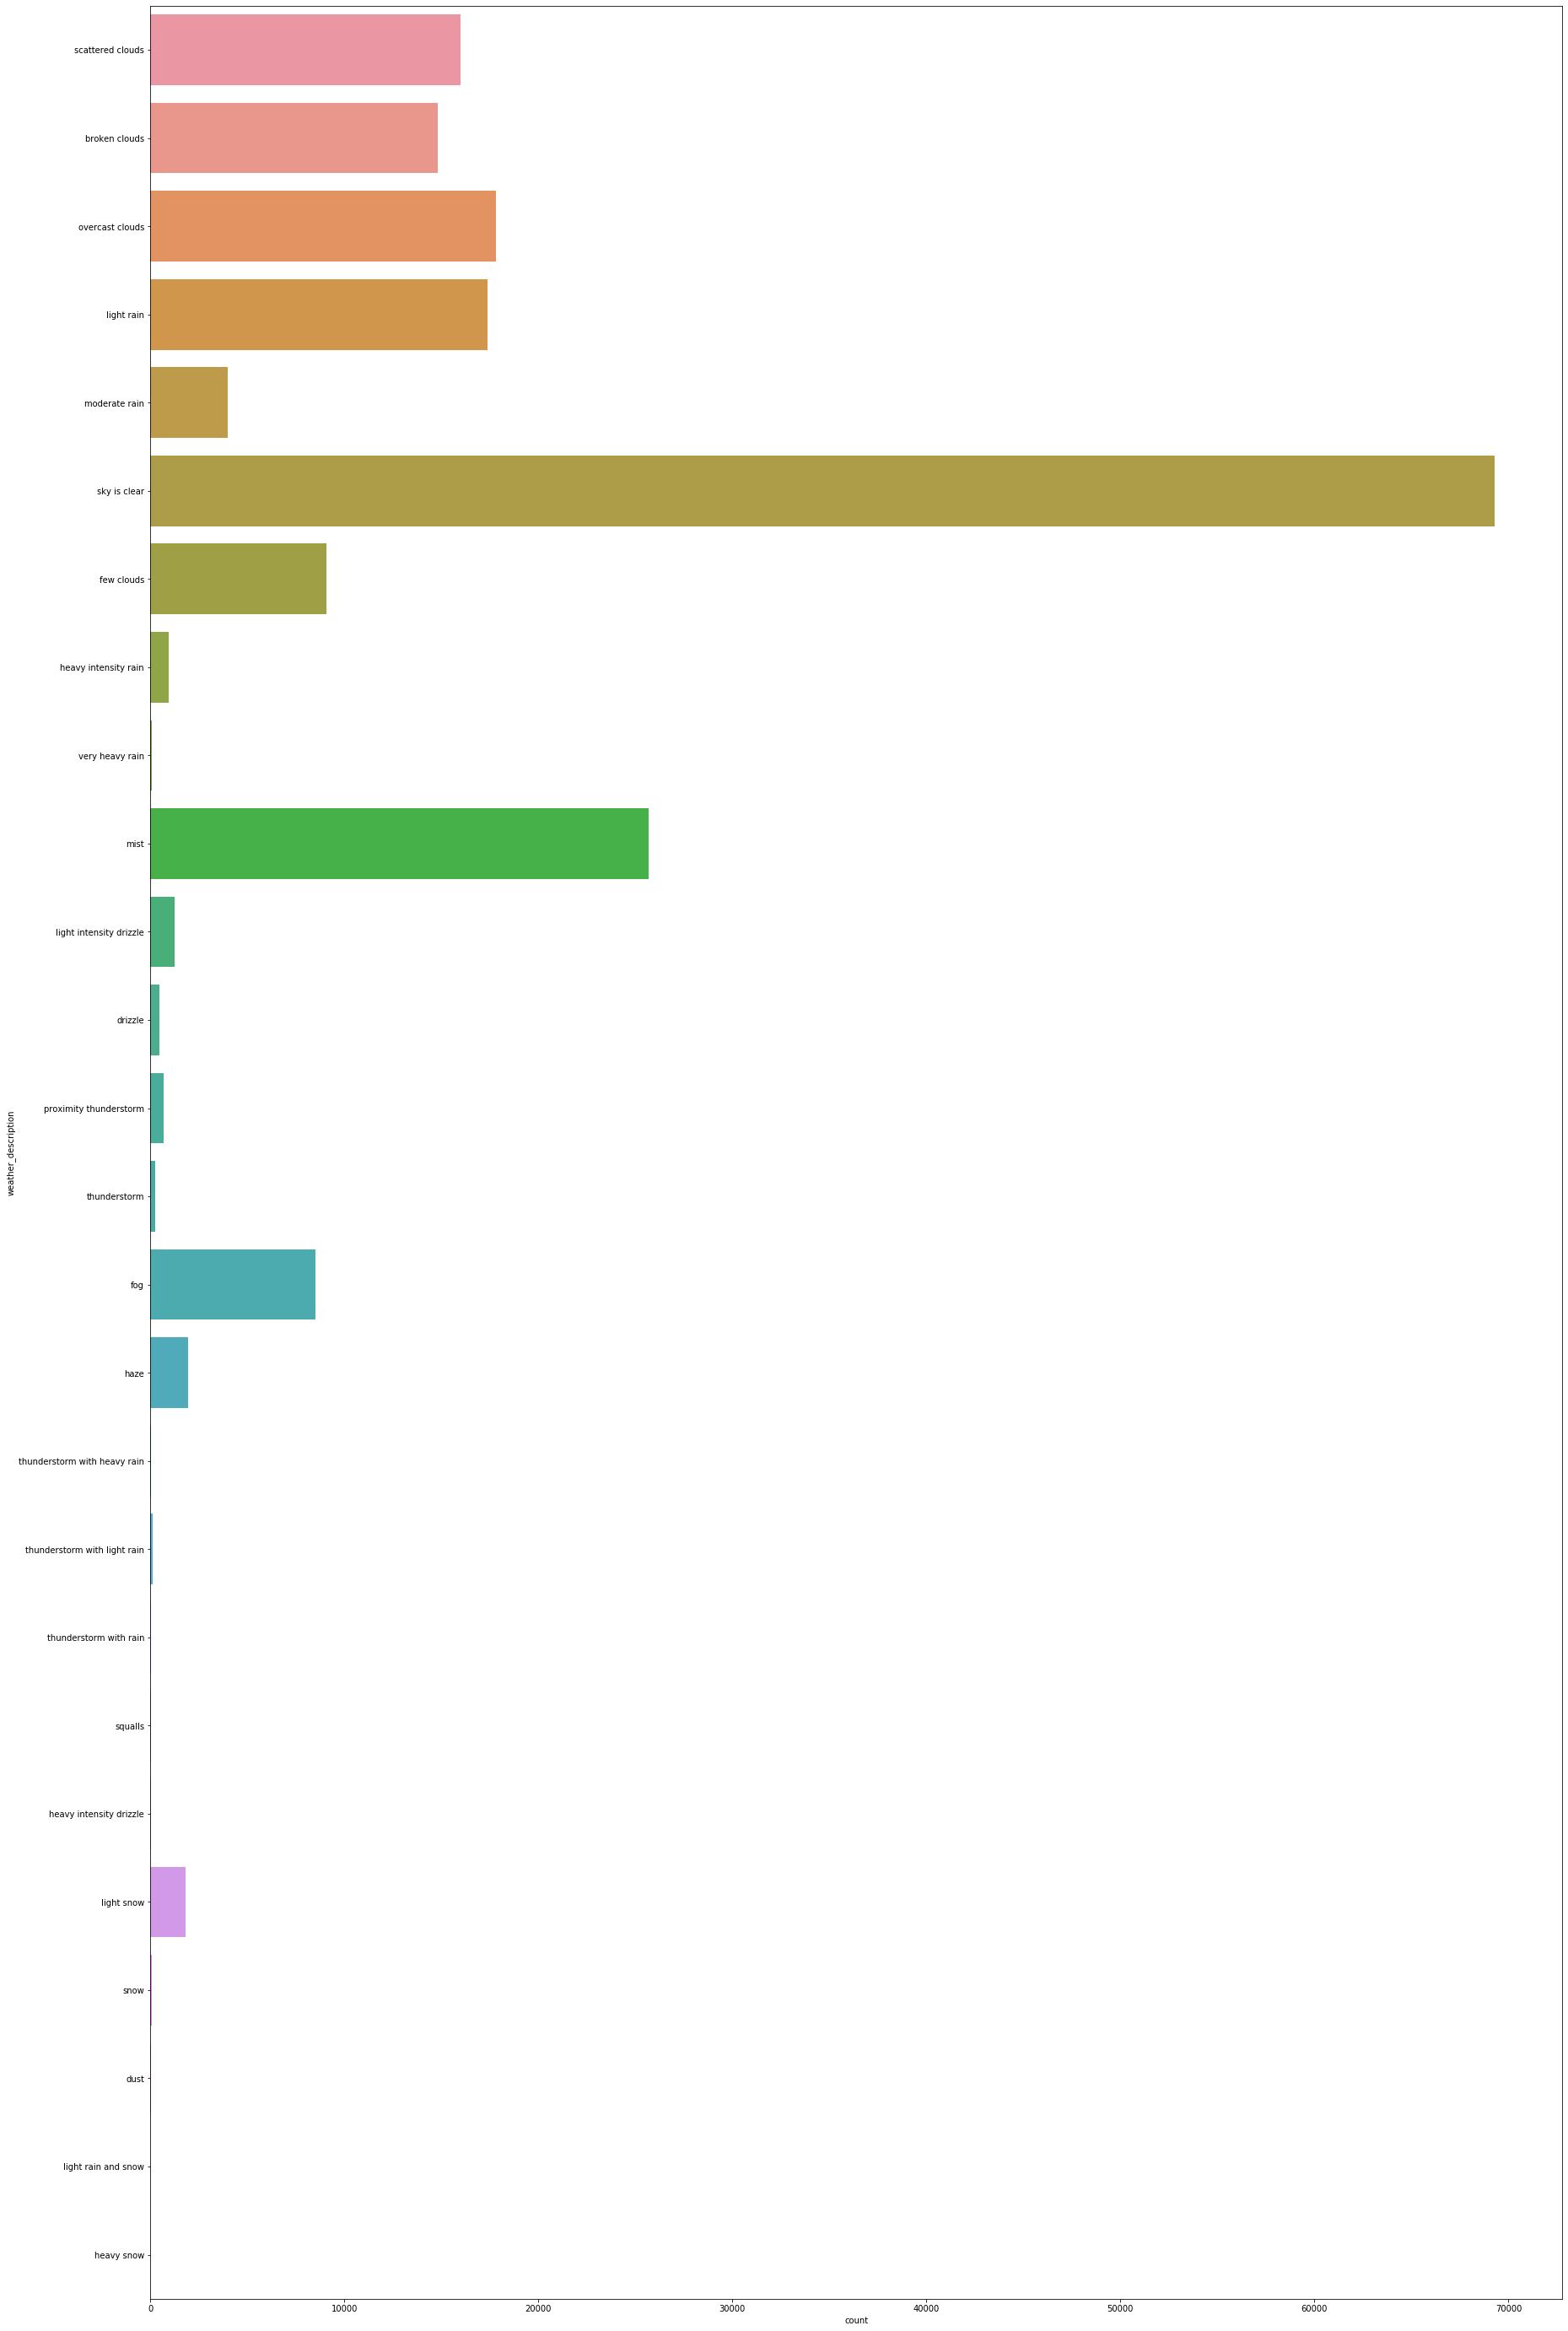

In [30]:
plt.figure(figsize=(30, 50))    #We are giving the size of figure
sns.countplot(y=crime_with_weather.weather_description)  #countplot taking counts of the columns which you choose 
plt.show() 